# EXAMPLE 2:
In this example we show how one can perturb the initial condition of the KdV equation.
This is done to investigate initial condition sensitivity. And demonstrate that one can instanciate two instances of the class for comparison. 

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
signal_params = ConfigDict(KDV_params_2)
signal_params.update(tmax=4,initial_condition='gaussian')

signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
signal_model_2 = ETD_KT_CM_JAX_Vectorised(signal_params)
print(signal_model.params)
print(signal_model.nmax)

I0000 00:00:1744361664.642430       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.0
nx: 256
tmax: 4
xmax: 1
xmin: 0

4000


Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [4]:
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_signal_2 = initial_signal + 1e-8*jnp.asarray(np.random.randn(*initial_signal.shape))
time = jnp.linspace(0, signal_model.params.tmax, signal_model.nmax)

In [5]:
final, all = signal_model.run(initial_signal, signal_model.nmax,None) 
final_2, all_2 = signal_model_2.run(initial_signal_2, signal_model.nmax,None)  

Put in the initial condition.

In [6]:

signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
signal_2 = jnp.concatenate([initial_signal_2[None,...], all_2], axis=0)


In [7]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k',label='signal')
    plt.plot(signal_model.x, signal_2[da_step,0,:], color='r',label='signal_perturbed')
    plt.legend()
    plt.show()

interact(plot, da_step=(0, signal_model.nmax))

interactive(children=(IntSlider(value=2000, description='da_step', max=4000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

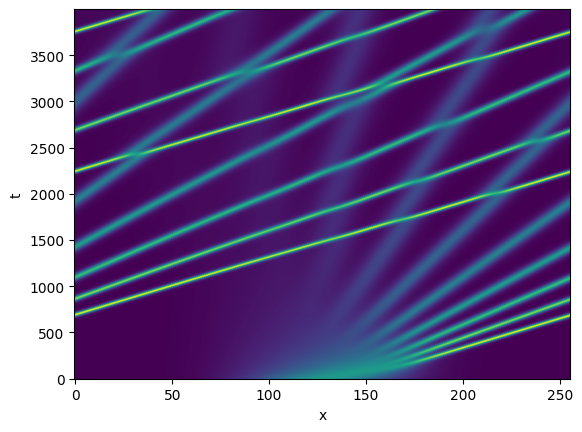

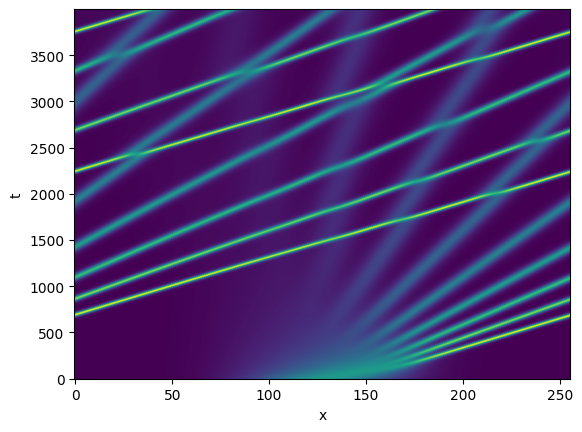

In [8]:
plt.imshow(all[:,0,:], aspect='auto',origin='lower')
plt.xlabel('x')
plt.ylabel('t')
plt.show()
plt.imshow(all_2[:,0,:], aspect='auto',origin='lower')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

Text(0, 0.5, 'L2 Relative difference')

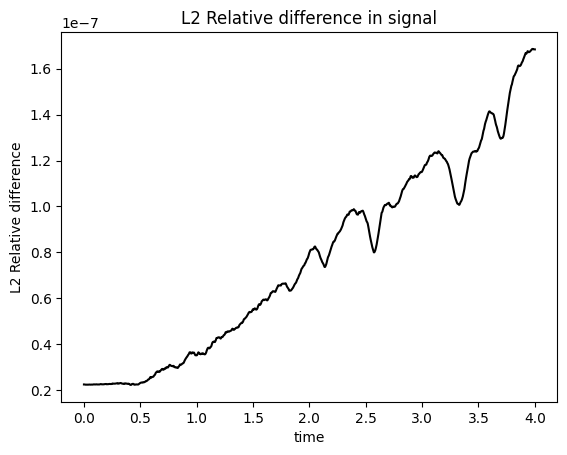

In [9]:
difference  = all[:,0,:] - all_2[:,0,:]
relative_error = jnp.linalg.norm(difference, axis=-1)/jnp.linalg.norm(all[:,0,:], axis=-1)

plt.title('L2 Relative difference in signal')
plt.plot(time, relative_error ,c='k')
plt.xlabel('time')
plt.ylabel('L2 Relative difference')

We see that the initial condition pertubation grows linearly in time.

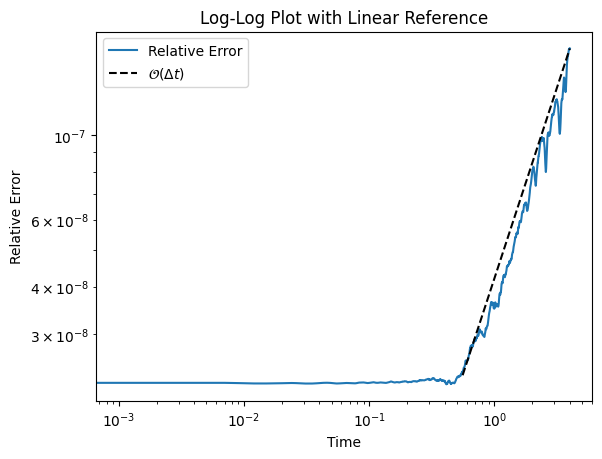

In [24]:
plt.loglog(time, relative_error, label='Relative Error')
mask = relative_error > 2.4e-8
plt.loglog(time[mask], time[mask] * relative_error[-1] / time[-1], '--', label=r'$\mathcal{O}(\Delta t)$', c='k')
plt.xlabel('Time')
plt.ylabel('Relative Error')
plt.legend()
plt.title('Log-Log Plot with Linear Reference')
plt.show()